In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Importing required libraries
import pandas as pd

# Loading the 
info_df = pd.read_csv("/Users/corycates/Documents/GitHub/Super_Hero/Data/superhero_info - superhero_info.csv")
powers_df = pd.read_csv("/Users/corycates/Documents/GitHub/Super_Hero/Data/superhero_powers - superhero_powers.csv")

# Displaying the first few rows of each dataframe for inspection
info_df.head(), powers_df.head()


(                 Hero|Publisher Gender               Race Alignment  \
 0          A-Bomb|Marvel Comics   Male              Human      good   
 1  Abe Sapien|Dark Horse Comics   Male      Icthyo Sapien      good   
 2            Abin Sur|DC Comics   Male            Ungaran      good   
 3     Abomination|Marvel Comics   Male  Human / Radiation       bad   
 4   Absorbing Man|Marvel Comics   Male              Human       bad   
 
   Hair color Eye color Skin color  \
 0    No Hair    yellow    Unknown   
 1    No Hair      blue       blue   
 2    No Hair      blue        red   
 3    No Hair     green    Unknown   
 4    No Hair      blue    Unknown   
 
                                    Measurements  
 0  {'Height': '203.0 cm', 'Weight': '441.0 kg'}  
 1   {'Height': '191.0 cm', 'Weight': '65.0 kg'}  
 2   {'Height': '185.0 cm', 'Weight': '90.0 kg'}  
 3  {'Height': '203.0 cm', 'Weight': '441.0 kg'}  
 4  {'Height': '193.0 cm', 'Weight': '122.0 kg'}  ,
     hero_names              

In [7]:
# Processing the info_df dataframe
info_df[['Hero', 'Publisher']] = info_df['Hero|Publisher'].str.split('|', expand=True)
info_df.drop('Hero|Publisher', axis=1, inplace=True)
info_df['Height'] = info_df['Measurements'].str.extract("'Height': '(\d+.\d+) cm'").astype(float)
info_df['Weight'] = info_df['Measurements'].str.extract("'Weight': '(\d+.\d+) kg'").astype(float)
info_df.drop('Measurements', axis=1, inplace=True)


In [8]:
# OneHot Encoding and transformations
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Gender', 'Race', 'Alignment', 'Hair color', 'Eye color', 'Skin color']
num_cols = ['Height', 'Weight']

cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='MISSING'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
num_pipe = make_pipeline(
    SimpleImputer(strategy='mean')
)
preprocessor = make_column_transformer(
    (cat_pipe, cat_cols),
    (num_pipe, num_cols),
    remainder='passthrough'
)
processed_data = preprocessor.fit_transform(info_df)

ohe = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder']
encoded_features = list(ohe.get_feature_names_out(cat_cols))
all_features = encoded_features + num_cols + ['Hero', 'Publisher']

processed_df = pd.DataFrame(processed_data, columns=all_features)


/usr/local/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Processing powers_df and merging
powers_df.rename(columns={'hero_names': 'Hero'}, inplace=True)
for power in ['Agility', 'Flight', 'Superspeed']:
    powers_df[power] = powers_df['Powers'].str.contains(power).astype(int)
powers_df.drop('Powers', axis=1, inplace=True)
combined_df = pd.merge(processed_df, powers_df, left_on='Hero', right_on='Hero', how='inner')


In [15]:
# Comparing the average weight of superheroes with and without Super Speed
average_weight_with_speed = combined_df[combined_df['Superspeed'] == 1]['Weight'].mean()
average_weight_without_speed = combined_df[combined_df['Superspeed'] == 0]['Weight'].mean()

average_weight_with_speed, average_weight_without_speed


(nan, 113.58963282937366)

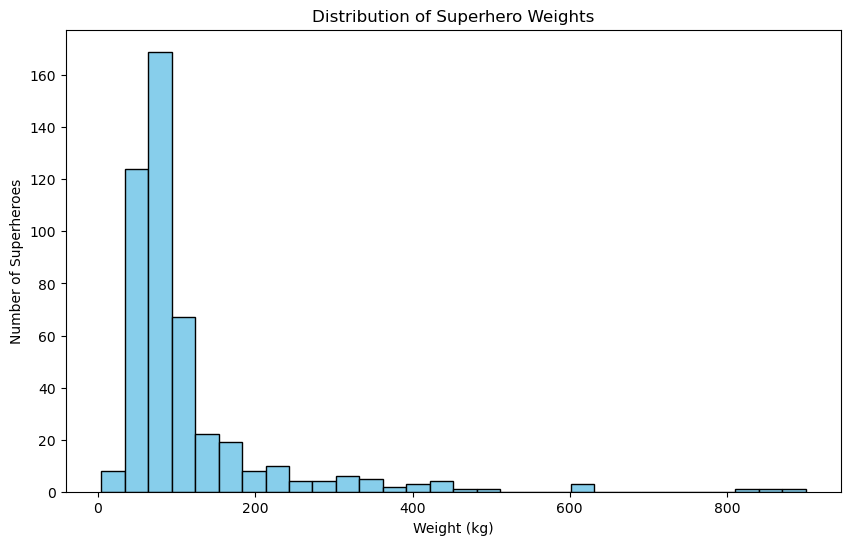

In [10]:
# Visualizing the distribution of superhero weights
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Weight'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Superhero Weights')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of Superheroes')
plt.show()


In [16]:
# Calculating the average height of heroes for each publisher
average_height_per_publisher = combined_df.groupby('Publisher')['Height'].mean()

average_height_per_publisher


Publisher
DC Comics            181.923913
Dark Horse Comics    176.909091
George Lucas         159.600000
Image Comics         211.000000
Marvel Comics        191.546128
Shueisha             171.500000
Star Trek            181.500000
Team Epic TV         180.750000
Unknown              178.000000
Name: Height, dtype: float64

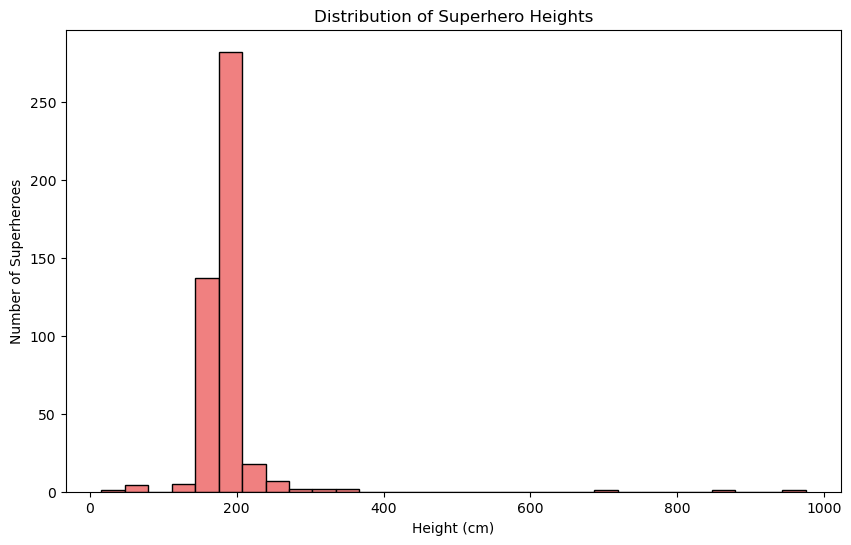

In [11]:
# Visualizing the distribution of superhero heights
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Height'].dropna(), bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Superhero Heights')
plt.xlabel('Height (cm)')
plt.ylabel('Number of Superheroes')
plt.show()


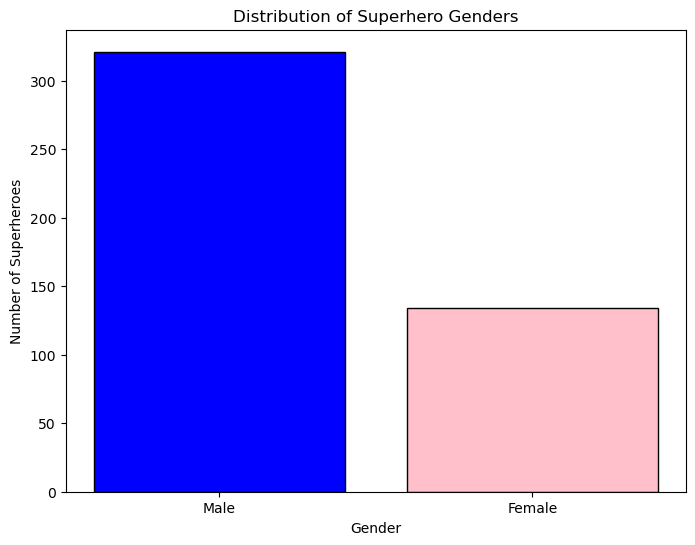

In [12]:
# Visualizing the distribution of superhero genders
genders = ['Male', 'Female']
counts = [combined_df['Gender_Male'].sum(), combined_df['Gender_Female'].sum()]

plt.figure(figsize=(8, 6))
plt.bar(genders, counts, color=['blue', 'pink'], edgecolor='black')
plt.title('Distribution of Superhero Genders')
plt.xlabel('Gender')
plt.ylabel('Number of Superheroes')
plt.show()


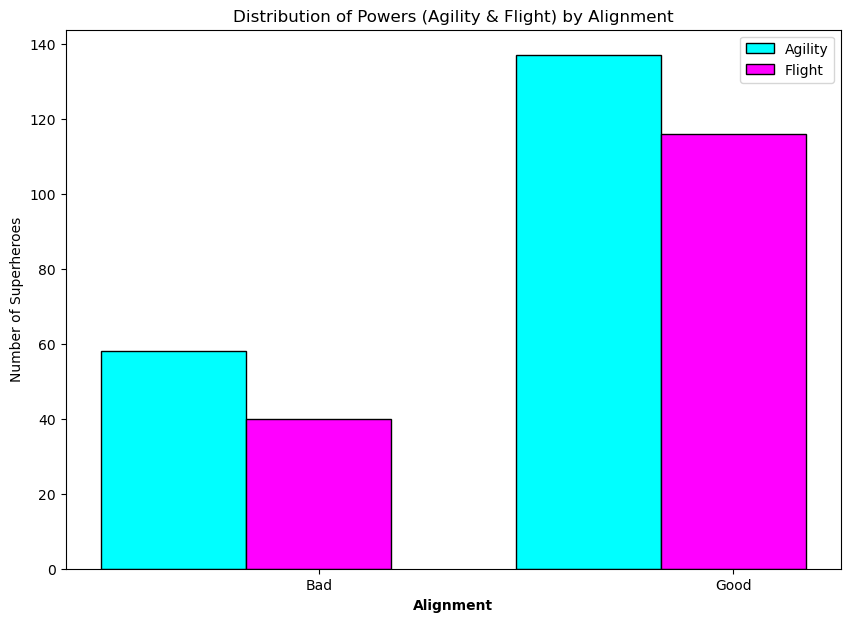

In [13]:
# Visualizing the distribution of powers by alignment
power_by_alignment = combined_df.groupby('Alignment_good').agg({'Agility': 'sum', 'Flight': 'sum'}).reset_index()
labels = ['Bad', 'Good']
agility_counts = power_by_alignment['Agility']
flight_counts = power_by_alignment['Flight']

bar_width = 0.35
r1 = range(len(agility_counts))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 7))
plt.bar(r1, agility_counts, width=bar_width, color='cyan', edgecolor='black', label='Agility')
plt.bar(r2, flight_counts, width=bar_width, color='magenta', edgecolor='black', label='Flight')
plt.xlabel('Alignment', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(agility_counts))], labels) #adjust the x-axis tick positions so that they align with the center of the grouped bars in the grouped bar chart.
plt.ylabel('Number of Superheroes')
plt.title('Distribution of Powers (Agility & Flight) by Alignment')
plt.legend()
plt.show()


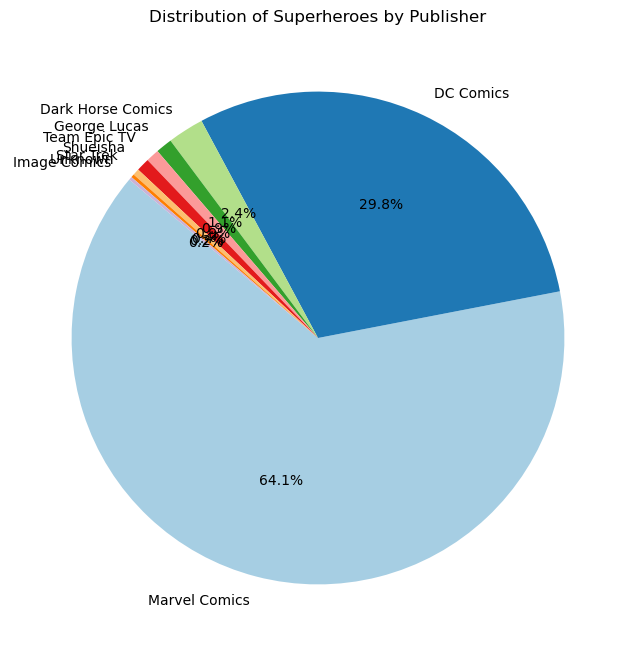

In [14]:
# Visualizing the distribution of superheroes by publisher
publisher_distribution = combined_df['Publisher'].value_counts()

plt.figure(figsize=(10, 8))
publisher_distribution.plot.pie(autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Superheroes by Publisher')
plt.ylabel('')
plt.show()


## Analysis of Superhero Physical Attributes (Weight & Height)

From the histograms, we can observe:

- Most superheroes weigh between 50 kg and 150 kg, with a few outliers weighing significantly more.

- The majority of superheroes have heights ranging from 150 cm to 200 cm, with some being considerably taller.

## Analysis of Superhero Genders

There are more male superheroes than female ones. The dominance of male superheroes in the dataset reflects historical trends in comic book publishing.

## Distribution of Powers (Agility & Flight) by Alignment

Both agility and flight are common traits among superheroes. From the grouped bar chart, we observe that good superheroes are slightly more likely to possess these powers.

## Distribution of Superheroes by Publisher

Marvel Comics and DC Comics dominate the dataset. The landscape of the superhero genre is heavily influenced by these major publishers.